# Wrangle and Analyze Data

### Imports

In [78]:
import pandas as pd
import tweepy
import requests as rq
import time
import json

### Read Data from Sources

#### Open DogRates Twitter Archive with *Pandas*

In [2]:
# Specific Dtypes for columns and date columns to parse
archive_dtypes = {'tweet_id':str, 'in_reply_to_status_id': str, 'in_reply_to_user_id': str, 'retweeted_status_id':str, 'retweeted_status_user_id':str}
archive_parse_dates = ['timestamp', 'retweeted_status_timestamp']

archive_df = pd.read_csv('twitter-archive-enhanced.csv', dtype=archive_dtypes, parse_dates=archive_parse_dates)

#### Get Tweets with *Tweepy*

In [3]:
retry_count = 0

while True:
    try:
        # open tweet detailed tweet archive file saved locally
        with open('tweet_json.txt', 'r') as fr:
            tweets = pd.io.json.json_normalize(
                        json.load(fr)
                     )
        break
    
    except FileNotFoundError as e:
        # list of tweets to download from the archive file
        tweet_ids = archive_df.tweet_id.unique().tolist()
        tweets = []

        for t in tweet_ids:
            try:
                # Parsing Tweepy objects: https://stackoverflow.com/questions/27900451
                twitter_keys = pd.read_json('twitterkeys.json', typ='series')
                twitter_auth = tweepy.OAuthHandler(twitter_keys['ConsumerAPIKey'], twitter_keys['ConsumerSecret'])
                twitter_auth.set_access_token(twitter_keys['AccessToken'], twitter_keys['AccessTokenSecret'])
                twitter = tweepy.API(twitter_auth, parser=tweepy.parsers.JSONParser(),
                                     wait_on_rate_limit=True,
                                     wait_on_rate_limit_notify=True)

                # get tweets one-by-one because tweepy.statuses_lookup doesn't support tweet_mode=extended
                tweets.append(
                    twitter.get_status(t, tweet_mode='extended', include_entities=True, trim_user=True)
                )

            except tweepy.TweepError as te:
                #swallow 'status not found' errors, raise all others
                if(te.api_code != 144):
                    raise

            #delay to reduce request rate; 15m limiting causes proxy timeout on intranet    
            time.sleep(.2)

        # write file to disk to avoid re-downloading
        with open('tweet_json.txt', 'w') as fw:
            json.dump(tweets, fw)
        
        # if met maximum retries, raise an error
        retry_count = retry_count + 1
        if retry_count == 4:
            raise

#### Download Image Predictions with *Requests*

In [35]:
retry_count = 0

while True:
    try: 
        # Open image prediction file saved locally
        images_df = pd.read_csv('image-predictions.tsv', sep='\t', dtype={'tweet_id':str})
        break
    
    except FileNotFoundError as e:
        # Use Requests library to download
        image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

        # Save the file
        with open('image-predictions.tsv', 'w') as fr:
            r = rq.get(image_predictions_url).text
            fr.write(r)
        
        # if met maximum retries, raise an error
        retry_count = retry_count + 1
        if retry_count == 4:
            raise

#### Download Tweets by ID from the Archive

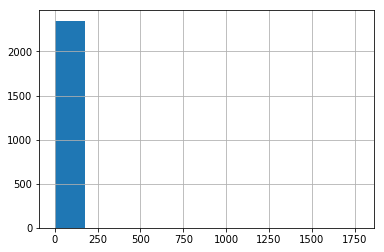

In [89]:
archive_df